# Assignment 1 - speech recognition - group 13
MACOS version

steps:
* data set preparation
* getting the label
* MFCC computation
* K-Fold CV to choose the algorithm
* splitting
* Ranzomized Search for the hyperparameters
* Random Forest algorithm
* Results


In [ ]:
import numpy as np
import pandas as pd
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from sklearn import metrics   
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score

## Data set preparation


In [6]:
# svn
!pip install svn
import svn
!svn checkout https://github.com/Jakobovski/free-spoken-digit-dataset/trunk/recordings repo

Checked out revision 65.


In [8]:
n_mfcc = 20   # number of MFCC we will use
freq = 16000   # sampling rate

#getting the list of files from the GitHub repository
from pathlib import Path
audiofiles = [str(file) for file in Path().glob('repo/*.wav')]

# creating a dictionary to store data
data = {'mfcc':[], 'labels':[]}
for i,file in enumerate(audiofiles):
    fileid = file.split('_')[0]
    label  = fileid.split('/')[1]
    data["labels"].append(label)
    
    #load the audio files
    audio, sr = librosa.load(file, sr=freq)
        
    #compute the MFCCs for each audio file
    mfcc = librosa.feature.mfcc(audio, sr=freq, n_fft =512, n_mfcc = n_mfcc)
    feature_vector =np.mean(mfcc, axis = 1)
    
    #features_matrix[i,:] = feature_vector
    data["mfcc"].append(feature_vector)


In [9]:
# verify that I got all the 3000 audio files
print('Got {} rows of data'.format(len(data['mfcc'])))

# create the flattened matrix of MFCCs -->  go from a list of arrays to a 2D matrix
MFCC_matrix =np.asarray( data['mfcc'])

# ...same for the labels vector
LABELS_vector = np.asarray(data["labels"])

print('Dimension of vector of labels is: {}'.format(LABELS_vector.shape))
print('Dimension of matrix of feautures is: {}'.format(MFCC_matrix.shape))

Got 3000 rows of data
Dimension of vector of labels is: (3000,)
Dimension of matrix of feautures is: (3000, 20)


In [23]:
# listen to the last audio file loaded
ipd.Audio(audio, rate=sr)

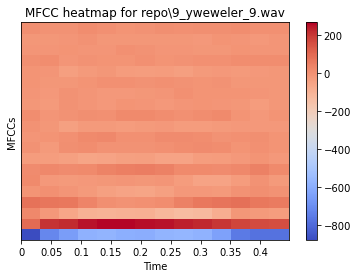

In [30]:
# check the MFCC heatmap for the last audio file
librosa.display.specshow(mfcc,x_axis = 'time',sr=sr)
plt.title('MFCC heatmap for {}'.format(file))
plt.xlabel('Time')
plt.ylabel('MFCCs')
plt.colorbar()
plt.show() 

## K-Fold cross validation : Random Forest / SVC / kNN 
### (using cross_val_score) (k=10)

The random state affects the splitting and that changes the accuracy score. We will evaluate the accuracy of these 3 algorithms using the K Fold cross validation. We will use the default values of the parameters during this process.


In [10]:
svm = SVC()                                  # initialize SVM
rf = RandomForestClassifier(n_jobs=2)        # initialize Random Forest
knn = KNeighborsClassifier()                 # initialize KNN

In [11]:
# support vector 
print('The accuracy for the SVM is {}'.
      format(cross_val_score(svm, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the SVM is 0.5243333333333333


In [12]:
# random forest
print('The accuracy for the Random Forest is {}'.
      format(cross_val_score(rf, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the Random Forest is 0.9133333333333333


In [13]:
# kNN
print('The accuracy for the KNN is {}'.
      format(cross_val_score(knn, MFCC_matrix, LABELS_vector, cv=10, scoring='accuracy').mean()))

The accuracy for the KNN is 0.8709999999999999


The Random Forest algorithm shows the best performance.

## Proportionate splitting 

In [14]:
# renaming
y = LABELS_vector
X = MFCC_matrix

# splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=0.2, stratify=y)


from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [15]:
# Check how the test sample are the same number for each digit
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{'0': 240,
 '1': 240,
 '2': 240,
 '3': 240,
 '4': 240,
 '5': 240,
 '6': 240,
 '7': 240,
 '8': 240,
 '9': 240}

## Random Forest - fine tuning
### using RandomizedSearchCV
Having chosen the Random Forest algorithm we can proceed and evaluate the best parameters to use. 

In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,
'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}

In [17]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# We have already created the base model to tune
# rf = RandomForestClassifier(n_jobs=2)

# Random search of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=2), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [18]:
#verify the hyperparameters picked for the model
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

## PREDICTIONS AND RESULTS

In [20]:
#predict labels
predicted = rf_random.predict(X_test)

CONFUSION MATRIX _ RANDOM FOREST:


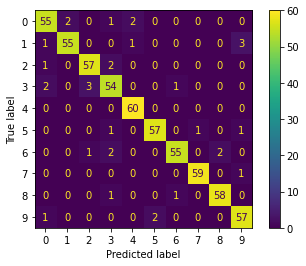

In [21]:
from sklearn.metrics import classification_report, accuracy_score

#confusioni matrix
print('CONFUSION MATRIX _ RANDOM FOREST:')
disp=metrics.plot_confusion_matrix(rf_random, X_test, y_test)

In [22]:
#classification report
print('CLASSIFICATION REPORT _ RANDOM FOREST:\n\n',classification_report(y_test,predicted))
print('Accuracy:\n',accuracy_score(y_test, predicted))

CLASSIFICATION REPORT _ RANDOM FOREST:

               precision    recall  f1-score   support

           0       0.92      0.92      0.92        60
           1       0.96      0.92      0.94        60
           2       0.93      0.95      0.94        60
           3       0.89      0.90      0.89        60
           4       0.95      1.00      0.98        60
           5       0.97      0.95      0.96        60
           6       0.96      0.92      0.94        60
           7       0.98      0.98      0.98        60
           8       0.97      0.97      0.97        60
           9       0.92      0.95      0.93        60

    accuracy                           0.94       600
   macro avg       0.95      0.94      0.94       600
weighted avg       0.95      0.94      0.94       600

Accuracy:
 0.945


In [52]:
# check of the probabilities for a random sample
print("The label for this sample in y_test is {}".format((y_test)[60]))
print("The random forest predicted for it {}".format((predicted[60])))
a = rf_random.predict_proba(X_test)
print("Each class got these probabilities: {}".format(a[60]))

The label for this sample in y_test is 8
The random forest predicted for it 8
Each class got these probabilities: [0.015      0.00166667 0.0025     0.08833333 0.00166667 0.00916667
 0.07833333 0.00666667 0.7825     0.01416667]
